## MGnify notebook: retrieve info from API

In [46]:
# import libraries
import requests
import os
import pandas as pd
import matplotlib.pyplot as plt
import json

In [47]:
def fetch_biomes_and_save(output_dir):
    """_summary_

    Args:
        output_dir (_type_): _description_
    """
    url = "https://www.ebi.ac.uk/metagenomics/api/v1/biomes"
    response = requests.get(url)
    if response.status_code == 200:
        biomes_data = response.json()
        biomes_list = [biome['id'] for biome in biomes_data['data']]
        
        with open(os.path.join(output_dir,"mgnify_biomes_list.txt"), 'w') as file:
            for biome_name in biomes_list:
                file.write(f"{biome_name}\n")
                
        print(f"Biomes list saved.")
        
    else:
        print("Failed to retrieve biomes")

In [48]:
def get_studies_and_analyses_summary(biome_name, experiment_type, output_dir = '../outputs'):
    """_summary_

    Args:
        biome_name (_type_): _description_
        experiment_type (_type_): _description_
        output_dir (str, optional): _description_. Defaults to '../outputs'.

    Returns:
        _type_: _description_
    """
    # set the urls
    urls = {"studies": "https://www.ebi.ac.uk/metagenomics/api/v1/studies", "analyses": "https://www.ebi.ac.uk/metagenomics/api/v1/analyses"}
    # common parts
    common_params = {"biome_name": biome_name}
    all_data = {"studies": [], "analyses": []}

    # connection request
    for key, url in urls.items():
        if key == "studies" and all_data["studies"]:
            continue

        params = common_params.copy()
        if key == "analyses":
            params.update({
                "lineage": biome_name,
                "experiment_type": experiment_type
            })

        page = 1
        
        while True:
            try:
                print(f"Retrieving data for page {page}...")
                params["page"] = page
                response = requests.get(url, params=params)
                response.raise_for_status()  # errors codes HTTP
                
                data = response.json()["data"]
                page_info = response.json()["meta"]["pagination"]
                all_data[key].extend(data)
                print(f"Page {page} retrieved successfully. Total pages: {page_info['pages']}")

                if page >= page_info["pages"]:
                    break
                page += 1
            except requests.exceptions.HTTPError as http_err:
                print(f"HTTP error occurred: {http_err} - Status code: {response.status_code}")
                break
            except Exception as err:
                print(f"An error occurred: {err}")
                break
        
        # save json files
        if key == "studies":
            output_file_path = os.path.join(output_dir, "mgnify_studies.json")
        else:
            output_file_path = os.path.join(output_dir, f"mgnify_analyses_{experiment_type}.json")
        
        with open(output_file_path, "w") as outfile:
            json.dump(all_data[key], outfile)
        print(f"{key.capitalize()} data for {experiment_type} saved to {output_file_path}")


    # building dataframes
    studies_columns = ['study_id', 'study_name', 'n_samples', 'bioproject', 'centre_name', 'biomes']
    studies_data = []
    for item in all_data['studies']:
        studies_data.append({
            'study_id': item['id'],
            'study_name': item['attributes'].get('study-name', ''),
            'n_samples': item['attributes'].get('samples-count', 0),
            'bioproject': item['attributes'].get('bioproject', ''),
            'centre_name': item['attributes'].get('centre-name', ''),
            'biomes': ", ".join([biome['id'] for biome in item['relationships']['biomes']['data']])
            })
    df_studies = pd.DataFrame(studies_data, columns=studies_columns)

    analyses_columns = ['analysis_id', 'experiment_type', 'pipeline_version', 'instrument_platform', 'study_id', 'sample_id', 'assembly_run_id']
    analyses_data = []
    for item in all_data['analyses']:
        analyses_data.append({
            'analysis_id': item['id'],
            'experiment_type': item['attributes'].get('experiment-type', ''),
            'pipeline_version': item['attributes'].get('pipeline-version', ''),
            'instrument_platform': item['attributes'].get('instrument-model', ''),
            'study_id': item['relationships']['study']['data'].get('id', '') if item['relationships'].get('study') else '',
            'sample_id': item['relationships']['sample']['data'].get('id', '') if item['relationships'].get('sample') else '',
            'assembly_run_id': item['relationships'].get('assembly', {}).get('data', {}).get('id', '') if item['attributes'].get('experiment-type') == 'assembly' else item['relationships'].get('run', {}).get('data', {}).get('id', '')
            })
    df_analyses = pd.DataFrame(analyses_data, columns=analyses_columns)

    # merging dataframe and return it
    df_summary = pd.merge(df_analyses, df_studies, on='study_id', how='left')
    
    return df_summary

### doubts
1. Possiamo creare i file json al di fuori del ciclo for? in questo modo posso creare solo due json e non avere il problema della sovrascrizione. 

In [49]:
if __name__ == "__main__":
    # setting the variables 
    biome = "root:Engineered:Wastewater"
    biome_lower = biome.replace(":", "_").lower()
    experiments = ("metagenomic","metatranscriptomic","assembly")
    output_path = '../outputs/'
    df_summary_dict = {}

    print('STARTING STEP 1: fetch_biomes_and_save')
    fetch_biomes_and_save(output_dir= output_path)

    print('STARTING STEP 2: get_studies_and_analyses_summary')
    for exp in experiments:
        print(f"Processing experiment type: {exp}")
        df_summary = get_studies_and_analyses_summary(biome_name=biome, experiment_type=exp)
        df_summary_dict[exp] = df_summary  # Aggiungi il DataFrame al dizionario

        # save the CSV file
        df_summary.to_csv(os.path.join(output_path, f"{biome_lower}_{exp}_summary.csv"), index=False)
        combined_df = pd.concat(df_summary_dict.values(), axis=0)


STARTING STEP 1: fetch_biomes_and_save
Biomes list saved.
STARTING STEP 2: get_studies_and_analyses_summary
Processing experiment type: metagenomic
Retrieving data for page 1...
Page 1 retrieved successfully. Total pages: 8
Retrieving data for page 2...
Page 2 retrieved successfully. Total pages: 8
Retrieving data for page 3...
Page 3 retrieved successfully. Total pages: 8
Retrieving data for page 4...
Page 4 retrieved successfully. Total pages: 8
Retrieving data for page 5...
Page 5 retrieved successfully. Total pages: 8
Retrieving data for page 6...
Page 6 retrieved successfully. Total pages: 8
Retrieving data for page 7...
Page 7 retrieved successfully. Total pages: 8
Retrieving data for page 8...
Page 8 retrieved successfully. Total pages: 8
Studies data for metagenomic saved to ../outputs/mgnify_studies.json
Retrieving data for page 1...
Page 1 retrieved successfully. Total pages: 40
Retrieving data for page 2...
Page 2 retrieved successfully. Total pages: 40
Retrieving data for p

## Descriptive analysis

In [50]:
combined_df.head(3)

,analysis_id,experiment_type,pipeline_version,instrument_platform,study_id,sample_id,assembly_run_id,study_name,n_samples,bioproject,centre_name,biomes
0,MGYA00166416,metagenomic,4.1,Illumina HiSeq 2500,MGYS00002383,ERS2488844,ERR2586218,Antibiotic manufacturing effluent enriches res...,6,PRJEB26809,UNIVERSITY OF GOTHENBURG,root:Engineered:Wastewater:Activated Sludge
1,MGYA00166417,metagenomic,4.1,Illumina HiSeq 2500,MGYS00002383,ERS2488846,ERR2586220,Antibiotic manufacturing effluent enriches res...,6,PRJEB26809,UNIVERSITY OF GOTHENBURG,root:Engineered:Wastewater:Activated Sludge
2,MGYA00166418,metagenomic,4.1,Illumina HiSeq 2500,MGYS00002383,ERS2488842,ERR2586216,Antibiotic manufacturing effluent enriches res...,6,PRJEB26809,UNIVERSITY OF GOTHENBURG,root:Engineered:Wastewater:Activated Sludge


In [51]:
combined_df.shape

(1614, 12)

In [52]:
combined_df.experiment_type.unique()

array(['metagenomic', 'metatranscriptomic', 'assembly'], dtype=object)

In [53]:
# 1. count number of unique 'study_id'
total_unique_studies = combined_df["study_id"].nunique()
print(f"Numero totale di study_id unici: {total_unique_studies}")

Numero totale di study_id unici: 117


In [54]:
# 2. count how many 'assembly_run_id' unique for each 'study_id'
assembly_runs_per_study = combined_df.groupby("study_id")["assembly_run_id"].nunique()
print("\nNumero di assembly_run_id unici per ciascun study_id:")
print(assembly_runs_per_study)


Numero di assembly_run_id unici per ciascun study_id:
study_id
MGYS00000423      1
MGYS00000425      1
MGYS00000555      1
MGYS00000597     16
MGYS00000606      1
               ... 
MGYS00005614      8
MGYS00005769     11
MGYS00005802      6
MGYS00005846    110
MGYS00006570    152
Name: assembly_run_id, Length: 117, dtype: int64


In [55]:
# 3. Descriptive analysis per 'n_samples'
desc_stats = combined_df.describe()
print("\nStatistiche descrittive per variabili numeriche:")
print(desc_stats)


Statistiche descrittive per variabili numeriche:
         n_samples
count  1614.000000
mean     95.480793
std      70.596550
min       1.000000
25%      30.000000
50%      81.000000
75%     179.000000
max     181.000000


In [56]:
# 4. Esplorare la distribuzione di 'experiment_type' e 'biomes'
experiment_type_counts = combined_df["experiment_type"].value_counts()
biomes_counts = combined_df["biomes"].value_counts()
print("\nDistribuzione di experiment_type:")
print(experiment_type_counts)
print("\nDistribuzione di biomes:")
print(biomes_counts)


Distribuzione di experiment_type:
experiment_type
metagenomic           985
assembly              530
metatranscriptomic     99
Name: count, dtype: int64

Distribuzione di biomes:
biomes
root:Engineered:Wastewater:Water and sludge                                                      708
root:Engineered:Wastewater                                                                       497
root:Engineered:Wastewater:Activated Sludge                                                      225
root:Engineered:Wastewater:Activated Sludge, root:Engineered:Wastewater:Industrial wastewater     70
root:Engineered:Wastewater:Industrial wastewater                                                  67
root:Engineered:Wastewater:Industrial wastewater:Petrochemical                                    24
root:Engineered:Wastewater:Nutrient removal:Dissolved organics (anaerobic)                        12
root:Engineered:Wastewater:Nutrient removal:Biological phosphorus removal:Activated sludge         8
root

In [57]:
# missing data
any_missing_data = combined_df.isnull().values.any()

print(f"Are there any missing data in the dataframe? {'yes' if any_missing_data else 'no'}")

Are there any missing data in the dataframe? no


In [63]:
combined_df.head()

,analysis_id,experiment_type,pipeline_version,instrument_platform,study_id,sample_id,assembly_run_id,study_name,n_samples,bioproject,centre_name,biomes
0,MGYA00166416,metagenomic,4.1,Illumina HiSeq 2500,MGYS00002383,ERS2488844,ERR2586218,Antibiotic manufacturing effluent enriches res...,6,PRJEB26809,UNIVERSITY OF GOTHENBURG,root:Engineered:Wastewater:Activated Sludge
1,MGYA00166417,metagenomic,4.1,Illumina HiSeq 2500,MGYS00002383,ERS2488846,ERR2586220,Antibiotic manufacturing effluent enriches res...,6,PRJEB26809,UNIVERSITY OF GOTHENBURG,root:Engineered:Wastewater:Activated Sludge
2,MGYA00166418,metagenomic,4.1,Illumina HiSeq 2500,MGYS00002383,ERS2488842,ERR2586216,Antibiotic manufacturing effluent enriches res...,6,PRJEB26809,UNIVERSITY OF GOTHENBURG,root:Engineered:Wastewater:Activated Sludge
3,MGYA00166419,metagenomic,4.1,Illumina HiSeq 2500,MGYS00002383,ERS2488841,ERR2586215,Antibiotic manufacturing effluent enriches res...,6,PRJEB26809,UNIVERSITY OF GOTHENBURG,root:Engineered:Wastewater:Activated Sludge
4,MGYA00166420,metagenomic,4.1,Illumina HiSeq 2500,MGYS00002383,ERS2488845,ERR2586219,Antibiotic manufacturing effluent enriches res...,6,PRJEB26809,UNIVERSITY OF GOTHENBURG,root:Engineered:Wastewater:Activated Sludge


In [64]:
combined_df.experiment_type.unique()

array(['metagenomic', 'metatranscriptomic', 'assembly'], dtype=object)

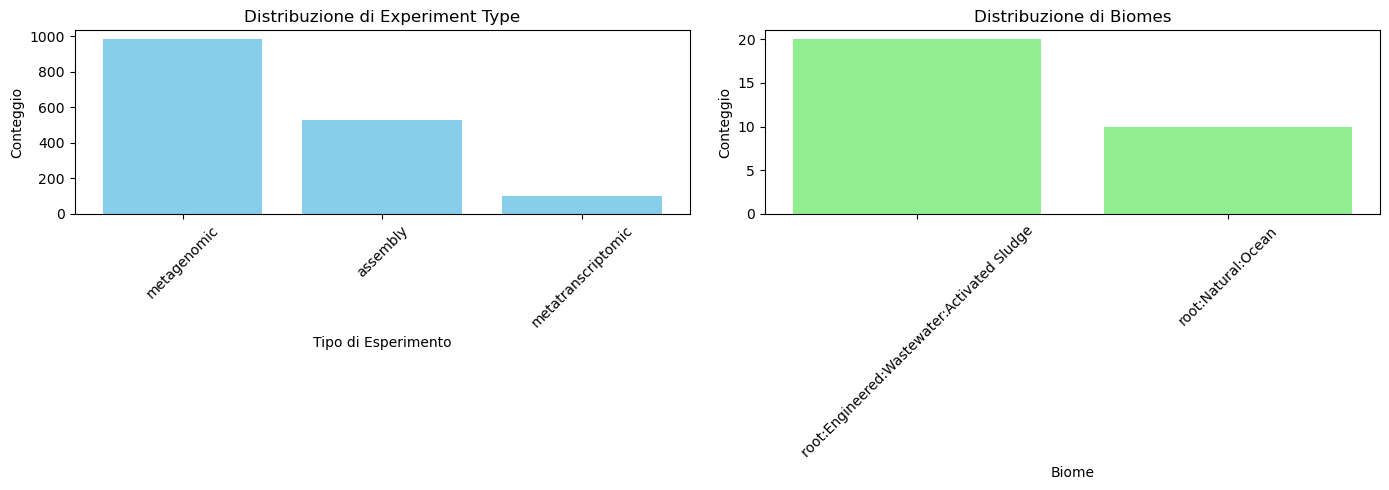

In [66]:
experiment_type_counts = combined_df["experiment_type"].value_counts()

# Creazione degli istogrammi
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Istogramma per experiment_type
ax[0].bar(experiment_type_counts.index, experiment_type_counts.values, color='skyblue')
ax[0].set_title('Distribuzione di Experiment Type')
ax[0].set_ylabel('Conteggio')
ax[0].set_xlabel('Tipo di Esperimento')
ax[0].tick_params(axis='x', rotation=45)

# Assumiamo che biomes_counts sia definito come prima. Se non è definito, calcolalo come segue:
# biomes_counts = combined_df["biomes"].value_counts()

# Istogramma per biomes
ax[1].bar(biomes_counts.keys(), biomes_counts.values(), color='lightgreen')
ax[1].set_title('Distribuzione di Biomes')
ax[1].set_ylabel('Conteggio')
ax[1].set_xlabel('Biome')
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

chiedere se per uno stesso campione esistono diverse versioni di pipeline, se si, occorre filtrare il dataframe e mantenere solo quella piu aggiornata.

In [62]:
combined_df.groupby("sample_id")["pipeline_version"]

In [61]:
combined_df["pipeline_version"] = pd.to_numeric(combined_df["pipeline_version"])

# Trova la versione più aggiornata della pipeline per ogni sample_id
df_updated = combined_df.loc[combined_df.groupby("sample_id")["pipeline_version"].idxmax()]

df_updated

,analysis_id,experiment_type,pipeline_version,instrument_platform,study_id,sample_id,assembly_run_id,study_name,n_samples,bioproject,centre_name,biomes
762,MGYA00131879,metagenomic,3.0,Illumina HiSeq 2000,MGYS00001851,DRS034400,DRR066655,Heterotrophic methanogens dominate in anaerobi...,6,PRJDB5067,TOKYO_PHARM,root:Engineered:Wastewater:Nutrient removal:Di...
767,MGYA00131888,metagenomic,3.0,Illumina HiSeq 2000,MGYS00001851,DRS034401,DRR066656,Heterotrophic methanogens dominate in anaerobi...,6,PRJDB5067,TOKYO_PHARM,root:Engineered:Wastewater:Nutrient removal:Di...
764,MGYA00131884,metagenomic,3.0,Illumina HiSeq 2000,MGYS00001851,DRS034402,DRR066657,Heterotrophic methanogens dominate in anaerobi...,6,PRJDB5067,TOKYO_PHARM,root:Engineered:Wastewater:Nutrient removal:Di...
766,MGYA00131887,metagenomic,3.0,Illumina HiSeq 2000,MGYS00001851,DRS034403,DRR066658,Heterotrophic methanogens dominate in anaerobi...,6,PRJDB5067,TOKYO_PHARM,root:Engineered:Wastewater:Nutrient removal:Di...
765,MGYA00131886,metagenomic,3.0,Illumina HiSeq 2000,MGYS00001851,DRS034404,DRR066659,Heterotrophic methanogens dominate in anaerobi...,6,PRJDB5067,TOKYO_PHARM,root:Engineered:Wastewater:Nutrient removal:Di...
...,...,...,...,...,...,...,...,...,...,...,...,...
387,MGYA00375781,assembly,4.1,Illumina HiSeq 1500,MGYS00002058,SRS976082,ERZ794914,EMG produced TPA metagenomics assembly of the ...,12,PRJEB22550,EMBL-EBI,root:Engineered:Wastewater:Activated Sludge
394,MGYA00216664,metagenomic,4.1,Illumina HiSeq 3000,MGYS00001312,ERS1426846,ERR1726013,Global surveillance of infectious diseases and...,179,PRJEB13831,DTU-GE,root:Engineered:Wastewater:Water and sludge
394,MGYA00375788,assembly,4.1,Illumina HiSeq 1500,MGYS00002058,SRS976605,ERZ794921,EMG produced TPA metagenomics assembly of the ...,12,PRJEB22550,EMBL-EBI,root:Engineered:Wastewater:Activated Sludge
385,MGYA00216655,metagenomic,4.1,Illumina HiSeq 3000,MGYS00001312,ERS1426846,ERR1726015,Global surveillance of infectious diseases and...,179,PRJEB13831,DTU-GE,root:Engineered:Wastewater:Water and sludge


creare una nuova variabile chiamata "name_id" in cui si considerano solo le prime 3 lettere e vengono printate nella nuova colonna. 